In [2]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import pickle
import torch

# Check device for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device (PyTorch):", device)

# Check device for TensorFlow
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU is available (TensorFlow)")
else:
    print("GPU is not available (TensorFlow)")

Using device (PyTorch): cuda
GPU is not available (TensorFlow)


In [3]:
def load_crema_data(crema_directory_list, crema_path):
    file_emotion = []
    file_path = []

    for file in crema_directory_list:
        file_path.append(os.path.join(crema_path, file))
        part = file.split('_')
        emotion = part[2]
        emotion_dict = {'SAD': 'sad', 'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fear', 'HAP': 'happy', 'NEU': 'neutral'}
        file_emotion.append(emotion_dict.get(emotion, 'Unknown'))
    
    return pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

In [4]:
def visualize_emotion_distribution(CREMA_df):
    emotion_counts = CREMA_df['Emotions'].value_counts()
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
    plt.title('Emotion Distribution', fontsize=16)
    plt.xlabel('Emotion', fontsize=14)
    plt.ylabel('Number of Samples', fontsize=14)
    plt.tight_layout()
    plt.show()


In [5]:
def extract_mfcc(dataframe, num_mfcc=13, n_fft=2048, hop_length=512, sample_rate=22050, max_length=130):
    data = {'labels': [], 'mfcc': []}
    for i in range(len(dataframe)):
        data['labels'].append(dataframe.iloc[i, 0])
        signal, _ = librosa.load(dataframe.iloc[i, 1], sr=sample_rate)
        mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
        
        mfcc = librosa.util.fix_length(mfcc, size=max_length, axis=1)
        data['mfcc'].append(np.asarray(mfcc).T)
    
    return pd.DataFrame(data)


In [6]:
def preprocess_data(df):
    mfcc_df = extract_mfcc(df)
    
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(mfcc_df['labels'])
    y = tf.keras.utils.to_categorical(y, num_classes=6)

    X = np.array([x for x in mfcc_df['mfcc']])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, X_validation, y_validation, label_encoder


In [7]:
def build_model(input_shape, num_classes=6):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    return model

In [8]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, label_encoder):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=1)

    y_pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='d', cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_encoder.classes_))

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


C:\Users\10\AppData\Local\Temp\ipykernel_6048\627759072.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


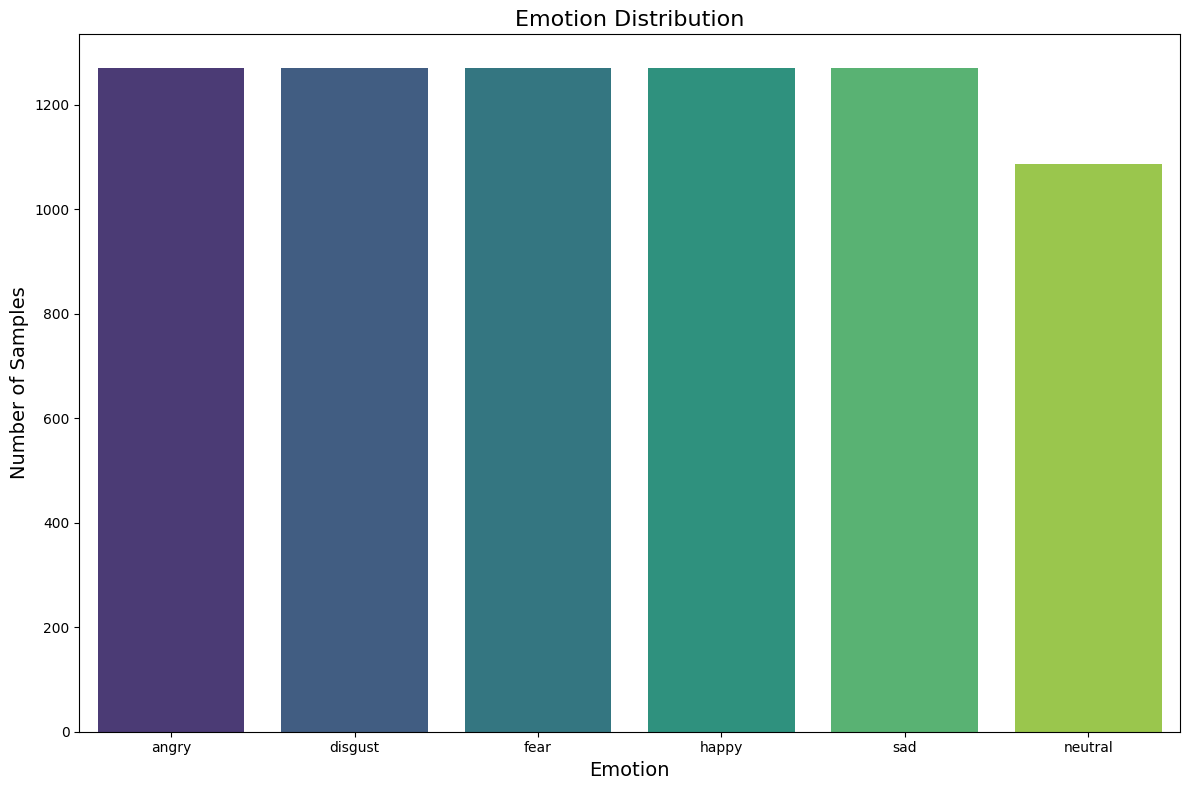

Epoch 1/30


c:\Users\10\anaconda3\envs\conda_venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


168/168 ━━━━━━━━━━━━━━━━━━━━ 57s 313ms/step - accuracy: 0.3025 - loss: 1.6306 - val_accuracy: 0.4037 - val_loss: 1.4592
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 54s 319ms/step - accuracy: 0.3982 - loss: 1.4707 - val_accuracy: 0.4119 - val_loss: 1.4579
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 50s 297ms/step - accuracy: 0.4165 - loss: 1.4402 - val_accuracy: 0.4216 - val_loss: 1.4127
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 51s 302ms/step - accuracy: 0.4429 - loss: 1.3877 - val_accuracy: 0.4306 - val_loss: 1.4178
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 52s 311ms/step - accuracy: 0.4495 - loss: 1.3953 - val_accuracy: 0.4351 - val_loss: 1.4012
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 49s 292ms/step - accuracy: 0.4510 - loss: 1.3827 - val_accuracy: 0.4425 - val_loss: 1.3746
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 50s 296ms/step - accuracy: 0.4538 - loss: 1.3691 - val_accuracy: 0.4254 - val_loss: 1.4034
Epoch 8/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 50s 298ms/step - accuracy: 0.4530 - loss: 1.3613 - val

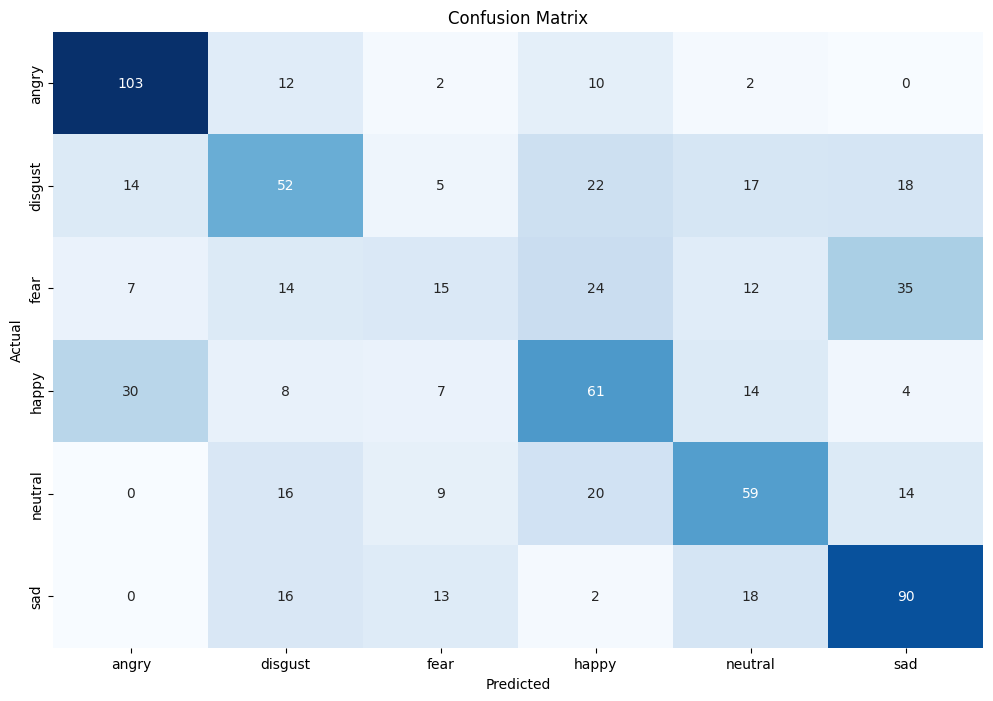

              precision    recall  f1-score   support

       angry       0.67      0.80      0.73       129
     disgust       0.44      0.41      0.42       128
        fear       0.29      0.14      0.19       107
       happy       0.44      0.49      0.46       124
     neutral       0.48      0.50      0.49       118
         sad       0.56      0.65      0.60       139

    accuracy                           0.51       745
   macro avg       0.48      0.50      0.48       745
weighted avg       0.49      0.51      0.49       745



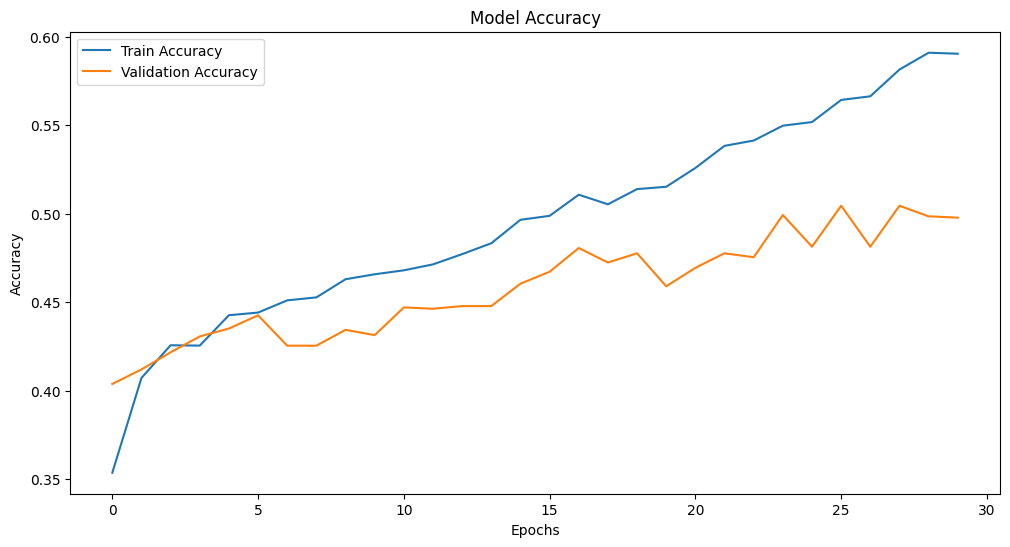

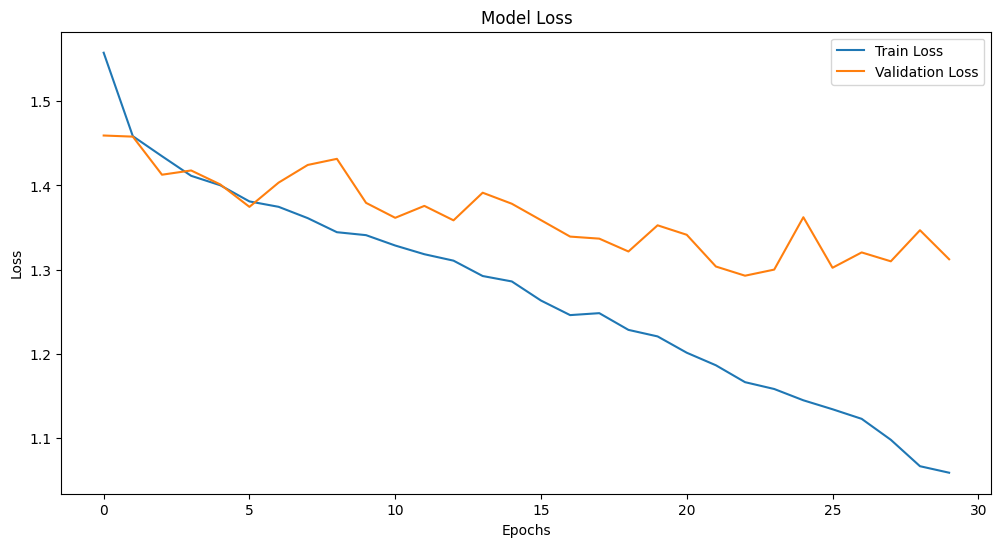

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5115 - loss: 1.2859


Test Accuracy: 51.01%


In [9]:
def main():
    Crema = "../datasets/CREMA_D"
    crema_directory_list = os.listdir(Crema)
    crema_df = load_crema_data(crema_directory_list, Crema)

    visualize_emotion_distribution(crema_df)

    X_train, X_test, y_train, y_test, X_validation, y_validation, label_encoder = preprocess_data(crema_df)

    model = build_model(input_shape=(None, 13), num_classes=y_train.shape[1])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    train_and_evaluate_model(model, X_train, y_train, X_validation, y_validation, X_test, y_test, label_encoder)

    model.save("../exported_files/lstm_CREMA_D.h5")
    with open("../exported_files/lstm_CREMA_D_label_encoder.pkl", "wb") as handle:
        pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

if __name__ == "__main__":
    main()
